# Chemistry

In [14]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import sys
sys.path.append('../../../../')

import matplotlib.pyplot as plt

from molgraph import chemistry

In [2]:
# Convert SMILES representation of molecule to an RDKit molecule
rdkit_mol = chemistry.molecule_from_string(
    'OCC1OC(C(C1O)O)n1cnc2c1ncnc2N')

print(type(rdkit_mol))

<class 'rdkit.Chem.rdchem.Mol'>


### 1. Obtain **features**

In [3]:
# Obtain RDKit atom and bond via the RDKit API
atom = rdkit_mol.GetAtoms()[0]
bond = rdkit_mol.GetBonds()[0]

symbol_feature = chemistry.features.Symbol()
bondtype_feature = chemistry.features.BondType()

print('Symbol:  ', symbol_feature(atom))
print('BondType:', bondtype_feature(bond))




Symbol:   O
BondType: SINGLE


### *Arguments of* ***features***

- `allowable_set` specifies what features should be considered
- `oov_size` specifies the number of bins alloted to "out-of-vocabulary" features (based on `allowable_set`) 
- `ordinal` specifies if encoding should be ordinal or not (nominal)

Importantly, the arguments above will only take effect when wrapped in a `chemistry.AtomicEncoder`, which occur automatically inside a `AtomicFeaturizer` or `AtomicTokenizer`.

In [4]:
print(chemistry.features.BondType())
print(chemistry.features.BondType(allowable_set=['SINGLE', 'DOUBLE'], oov_size=1, ordinal=False))

BondType(allowable_set=['SINGLE', 'AROMATIC', 'TRIPLE', 'DOUBLE'], ordinal=False, oov_size=0)
BondType(allowable_set=['SINGLE', 'DOUBLE'], ordinal=False, oov_size=1)


###  2. Pass features to **AtomicFeaturizer**

An `AtomicFeaturizer` (or `AtomicTokenizer`) can be built from a list of `features`. Note: if `ordinal=False` (default), `allowable_set` will be sorted internally via `sort()`. 

In [5]:
atom_encoder = chemistry.AtomicFeaturizer([
    chemistry.features.Symbol(['C', 'N', 'O'], oov_size=1),
    chemistry.features.Hybridization(['SP', 'SP2', 'SP3'], oov_size=1)
])

print('Symbol:       ', atom.GetSymbol())
print('Hybridization:', atom.GetHybridization().name)

# first and fifth bin is alloted to OOVs
print(atom_encoder(atom))

Symbol:        O
Hybridization: SP3
[0. 0. 0. 1. 0. 0. 0. 1.]


### *Create custom* ***features***

In [6]:
class AtomMass(chemistry.AtomicFeature):
    def __call__(self, x):
        mass = x.GetMass()
        if mass < 5:
            return 'x<5'
        elif mass < 40:
            return '5<x<40'
        else:
            return '40<x'

featurizer = chemistry.AtomicFeaturizer([
    AtomMass({'x<5', '5<x<40', '40<x'}), 
    chemistry.features.Symbol({'C', 'N'})
])
        
print('AtomMass:', atom.GetMass())
print('Symbol:  ', atom.GetSymbol())
print(featurizer(atom))

AtomMass: 15.999
Symbol:   O
[0. 1. 0. 0. 0.]


### 3. Pass **AtomicFeaturizer** to **MolecularGraphEncoder** to generate a **GraphTensor**

`MolecularGraphEncoder` encodes inputted molecule(s) as molecular graphs, namely as a `GraphTensor`.


Below a single molecule is encoded as a `GraphTensor`

In [7]:

atom_encoder = chemistry.AtomicFeaturizer([
    chemistry.features.Symbol(allowable_set={'C', 'N', 'O'})
])
bond_encoder = chemistry.AtomicFeaturizer([
    chemistry.features.BondType(allowable_set={'SINGLE', 'DOUBLE'})
])

mol_encoder = chemistry.MolecularGraphEncoder(
    atom_encoder=atom_encoder,                                    # not default, required
    bond_encoder=bond_encoder,                                    # not default, optional
    positional_encoding_dim=16,                                   # default
    self_loops=False,                                             # default
    molecule_from_string_fn=chemistry.molecule_from_string        # default
)

print(mol_encoder(rdkit_mol))

GraphTensor(
  edge_dst=<tf.Tensor: shape=(42,), dtype=int32>,
  edge_src=<tf.Tensor: shape=(42,), dtype=int32>,
  node_feature=<tf.Tensor: shape=(19, 3), dtype=float32>,
  edge_feature=<tf.Tensor: shape=(42, 2), dtype=float32>,
  positional_encoding=<tf.Tensor: shape=(19, 16), dtype=float32>,
  graph_indicator=<tf.Tensor: shape=(19,), dtype=int32>)


Here, a list of molecules are encoded as a `GraphTensor`

In [8]:
molecules = [
    'OCC1OC(C(C1O)O)n1cnc2c1ncnc2N',
    'C(C(=O)O)N',
    'C1=CC(=CC=C1CC(C(=O)O)N)O'
]
# Uses multiprocessing by default
graph_tensor = mol_encoder(molecules, processes=8)
print(graph_tensor, end='\n\n')

GraphTensor(
  node_feature=<tf.RaggedTensor: shape=(3, None, 3), dtype=float32>,
  edge_feature=<tf.RaggedTensor: shape=(3, None, 2), dtype=float32>,
  positional_encoding=<tf.RaggedTensor: shape=(3, None, 16), dtype=float32>,
  edge_dst=<tf.RaggedTensor: shape=(3, None), dtype=int32>,
  edge_src=<tf.RaggedTensor: shape=(3, None), dtype=int32>)



### *Inspect generated molecular* ***GraphTensor***

#### Inspect the whole graph

In [9]:
print('node_feature:', graph_tensor.node_feature, end='\n\n')
print('edge_feature:', graph_tensor.edge_feature, end='\n\n')
print('edge_dst:', graph_tensor.edge_dst, end='\n\n')
print('edge_src:', graph_tensor.edge_src, end='\n\n')

node_feature: <tf.RaggedTensor [[[0.0, 0.0, 1.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 0.0, 1.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 0.0, 1.0],
  [0.0, 0.0, 1.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0]], [[1.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0],
                     [0.0, 0.0, 1.0],
                     [0.0, 0.0, 1.0],
                     [0.0, 1.0, 0.0]], [[1.0, 0.0, 0.0],
                                        [1.0, 0.0, 0.0],
                                        [1.0, 0.0, 0.0],
                                        [1.0, 0.0, 0.0],
                                        [1.0, 0.0, 0.0],
                                        [1.0, 0.0, 0.0],
                                        [1.0, 0.0, 0.0],
                                        [1.0, 0.0, 0.0],
                   

#### Extract the second subgraph (molecule)

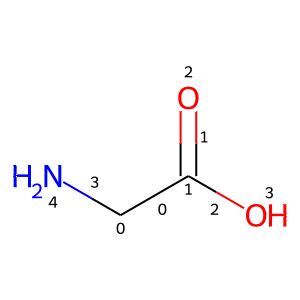

In [10]:
from molgraph.chemistry import vis

index = 1

# visualize the second molecule of the GraphTensor as reference
vis.visualize_molecule(
    molecule=molecules[index], 
    atom_index=True, 
    bond_index=True
)

In [11]:
print(graph_tensor[index], end='\n\n')
print('node_feature:', graph_tensor[index].node_feature, end='\n\n')
print('edge_feature:', graph_tensor[index].edge_feature, end='\n\n')
print('edge_dst:', graph_tensor[index].edge_dst, end='\n\n')
print('edge_src:', graph_tensor[index].edge_src, end='\n\n')

GraphTensor(
  node_feature=<tf.Tensor: shape=(5, 3), dtype=float32>,
  edge_feature=<tf.Tensor: shape=(8, 2), dtype=float32>,
  positional_encoding=<tf.Tensor: shape=(5, 16), dtype=float32>,
  edge_dst=<tf.Tensor: shape=(8,), dtype=int32>,
  edge_src=<tf.Tensor: shape=(8,), dtype=int32>,
  graph_indicator=<tf.Tensor: shape=(5,), dtype=int32>)

node_feature: tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)

edge_feature: tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(8, 2), dtype=float32)

edge_dst: tf.Tensor([0 0 1 1 1 2 3 4], shape=(8,), dtype=int32)

edge_src: tf.Tensor([1 4 0 2 3 1 1 0], shape=(8,), dtype=int32)



#### Merge subgraphs into a single disjoint graph

In [12]:
graph_tensor = graph_tensor.merge()
print(graph_tensor, end='\n\n')
print('node_feature:', graph_tensor.node_feature, end='\n\n')
print('edge_feature:', graph_tensor.edge_feature, end='\n\n')
print('edge_dst:', graph_tensor.edge_dst, end='\n\n')
print('edge_src:', graph_tensor.edge_src, end='\n\n')
print('graph_indicator:', graph_tensor.graph_indicator)

GraphTensor(
  node_feature=<tf.Tensor: shape=(37, 3), dtype=float32>,
  edge_feature=<tf.Tensor: shape=(76, 2), dtype=float32>,
  positional_encoding=<tf.Tensor: shape=(37, 16), dtype=float32>,
  edge_dst=<tf.Tensor: shape=(76,), dtype=int32>,
  edge_src=<tf.Tensor: shape=(76,), dtype=int32>,
  graph_indicator=<tf.Tensor: shape=(37,), dtype=int32>)

node_feature: tf.Tensor(
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(37, 3), dtype=float32)

edge_feature: tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0

#### Separate the single disjoint graph into three subgraphs

In [13]:
graph_tensor = graph_tensor.separate()
print(graph_tensor, end='\n\n')
print('node_feature:', graph_tensor.node_feature, end='\n\n')
print('edge_feature:', graph_tensor.edge_feature, end='\n\n')
print('edge_dst:', graph_tensor.edge_dst, end='\n\n')
print('edge_src:', graph_tensor.edge_src, end='\n\n')

GraphTensor(
  node_feature=<tf.RaggedTensor: shape=(3, None, 3), dtype=float32>,
  edge_feature=<tf.RaggedTensor: shape=(3, None, 2), dtype=float32>,
  positional_encoding=<tf.RaggedTensor: shape=(3, None, 16), dtype=float32>,
  edge_dst=<tf.RaggedTensor: shape=(3, None), dtype=int32>,
  edge_src=<tf.RaggedTensor: shape=(3, None), dtype=int32>)

node_feature: <tf.RaggedTensor [[[0.0, 0.0, 1.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 0.0, 1.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 0.0, 1.0],
  [0.0, 0.0, 1.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0]], [[1.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0],
                     [0.0, 0.0, 1.0],
                     [0.0, 0.0, 1.0],
                     [0.0, 1.0, 0.0]], [[1.0, 0.0, 0.0],
                                        [1.0, 0.0, 0.0],
            